In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.signal import get_window
from numba import njit
from numpy.typing import NDArray
import os 
from tqdm import tqdm


# Main functions

In [2]:
# fsle and fsrv with uncertainties from bootstrap method
@njit
def bootstrap_fsle_fsrv(xtra,ytra,u,v,pairs_to_monitor_original,dt,R0,r=1.2,nbs=1000):
    #print(nbs)
    # fsle
    # number of thresholds for FSLE
    Nthr=45
    ntzeros=int(len(xtra))
    # thresholds for FSLE
    thresh=np.zeros(Nthr)
    thresh = [R0 * r**k for k in range(Nthr)]
    lambda_xp=np.zeros((Nthr,nbs))
    fsrv_xp=np.zeros((Nthr,nbs))
    nstat_fsle_xp=np.zeros((Nthr,nbs))
    # arrays for statistics on bootstrap samples
    pairs_to_monitor = pairs_to_monitor_original

    for ibs in range(nbs):
        nsample=len(pairs_to_monitor_original)
        d2=np.zeros((nsample,ntzeros))
        kpairold_xp=np.zeros(nsample)
        kpair_xp=np.zeros(nsample)
        timeold_xp=np.zeros(nsample)
        tau_xp=np.zeros(Nthr)
        fsrv_ibs=np.zeros(Nthr)
        # if ibs=0 then use original indices
        if ibs!=0:
            n_samples=pairs_to_monitor_original.shape[0]
            # Randomly select row indices with replacement
            indices = np.random.choice(pairs_to_monitor_original.shape[0], size=n_samples, replace=True)
            pairs_to_monitor = pairs_to_monitor_original[indices]
    
        # print("bootstrap sample ibs=%d" %ibs)
        # loop on time
        for ifr in range(ntzeros):
            it=ifr*dt
            for ip,pair in enumerate(pairs_to_monitor):
                d2[ip,ifr]=(xtra[ifr,pair[0]]-xtra[ifr,pair[1]])**2+(ytra[ifr,pair[0]]-ytra[ifr,pair[1]])**2
                # fsle
                d=np.sqrt(d2[ip,ifr])
                # Lagrangian 2nd order spatial structure function (fsrv) 
                v2 = (u[ifr,pair[0]]-u[ifr,pair[1]])**2 + (v[ifr,pair[0]]-v[ifr,pair[1]])**2
                kpair_xp[ip]=int(1./np.log(r)*np.log(d/R0))
                if kpair_xp[ip]>kpairold_xp[ip]:
                    tau_xp[int(kpairold_xp[ip])]=tau_xp[int(kpairold_xp[ip])]+it-timeold_xp[ip]
                    nstat_fsle_xp[int(kpairold_xp[ip]),ibs]=nstat_fsle_xp[int(kpairold_xp[ip]),ibs]+1
                    fsrv_ibs[int(kpairold_xp[ip])]=fsrv_ibs[int(kpairold_xp[ip])]+v2
                    kpairold_xp[ip]=kpair_xp[ip]
                    timeold_xp[ip]=it

        for k in range(Nthr):
            if nstat_fsle_xp[k,ibs] != 0:
                lambda_xp[k,ibs]=np.log(r)/(tau_xp[k]/nstat_fsle_xp[k,ibs])
                fsrv_xp[k,ibs]=fsrv_ibs[k]/(nstat_fsle_xp[k,ibs])
    
    return thresh, lambda_xp, fsrv_xp, nstat_fsle_xp


# pairs to monitor
def pmonitor(x,y, R0,iicc_flag):
    #print('num_pairs %d' %num_pairs)
    monitor=[]
    for particle in range(len(x)):
        #print('particle %d'%particle)
        for forward in range(particle+1,len(x)):
            #print('forward %d'%forward)
            temp_separation=((x[particle]-x[forward])**2+(y[particle]-y[forward])**2)**0.5
            if temp_separation <= R0:
                monitor.append([particle,forward])

    monitor=np.array(monitor)
    ###### 
    # if localized i.c.
    if iicc_flag==0:
        indices = np.random.choice(monitor.shape[0], size=len(x)/2, replace=False) ## num_pairs -> len(x)/2
        scra = monitor[indices]
        monitor = scra
    #######
    
    return monitor

#finite-difference derivative (for Lagrangian velocities)
@njit(nopython=True)
def finite_difference_time_derivative(array, h, method='central'):
    """
    Compute the finite difference approximation of the time derivative for each spatial position (x).
    
    Parameters:
        array (2D numpy array): The array where the first dimension is time (t) and the second is space (x).
        h (float): The time step size.
        method (str): The method to use: 'forward', 'backward', or 'central' (default is 'central').
        
    Returns:
        2D numpy array: The derivative of the input array with respect to time at each position (t, x).
    """
    nt, nx = array.shape
    derivative = np.zeros_like(array)

    for j in range(nx):
        for i in range(1, nt-1):  # Central difference, avoid boundary points
            if method == 'central':
                derivative[i, j] = (array[i + 1, j] - array[i - 1, j]) / (2 * h)
            elif method == 'forward':
                if i < nt - 1:
                    derivative[i, j] = (array[i + 1, j] - array[i, j]) / h
            elif method == 'backward':
                if i > 0:
                    derivative[i, j] = (array[i, j] - array[i - 1, j]) / h
    
    # Handle the boundaries
    if method == 'forward':
        for j in range(nx):
            derivative[0, j] = (array[1, j] - array[0, j]) / h  # Forward at the start
            derivative[nt-1, j] = (array[nt-1, j] - array[nt-2, j]) / h  # Backward at the end
    elif method == 'backward':
        for j in range(nx):
            derivative[0, j] = (array[1, j] - array[0, j]) / h  # Forward at the start
            derivative[nt-1, j] = (array[nt-1, j] - array[nt-2, j]) / h  # Backward at the end
    elif method == 'central':
        for j in range(nx):
            derivative[0, j] = (array[1, j] - array[0, j]) / h  # Forward at the start
            derivative[nt-1, j] = (array[nt-1, j] - array[nt-2, j]) / h  # Backward at the end
    
    return derivative


# velocity field and one AB3 step in time
@njit
def update_particles_cellular(particles_x, particles_y, u1, v1, u2, v2, tt, ddtt, gamma,f):

    u = np.zeros_like(particles_x)
    v = np.zeros_like(particles_y)
    k= 4*2*np.pi/L_c[0]
    l= 3*2*np.pi/L_c[0]   
    
    for i in range(n_c):
        u_temp = (alpha_c[i] * np.sin(k_c[i] * (particles_x - epsilon_c[i] * np.sin(omega_c[i] * tt))) * np.cos(k_c[i] * (particles_y - epsilon_c[i] * np.sin(omega_c[i] * tt)))) 
        v_temp = (-alpha_c[i]  * np.cos(k_c[i] * (particles_x - epsilon_c[i] * np.sin(omega_c[i] * tt))) * np.sin(k_c[i] * (particles_y - epsilon_c[i] * np.sin(omega_c[i] * tt)))) 
        #u_temp = (alpha_c[i] * np.sin(k_c[i] * (particles_x)) * np.cos(k_c[i] * (particles_y)))
        #v_temp=(-alpha_c[i]  * np.cos(k_c[i] * (particles_x)) * np.sin(k_c[i] * (particles_y))) 
        u += u_temp
        v += v_temp
        u += np.sqrt(np.mean(u_temp**2+v_temp**2))*gamma*np.cos(2*np.pi*f * tt)
        v -= np.sqrt(np.mean(u_temp**2+v_temp**2))*gamma*np.sin(2*np.pi*f * tt)
    
    # First 2 steps as Euler
    if tt//ddtt <= 2:
        u1 = np.copy(u)
        v1 = np.copy(v)
        u2 = np.copy(u)
        v2 = np.copy(v)        
        
    particles_x = particles_x + (ddtt/12)*(23*u - 16*u1 +5*u2)
    particles_y = particles_y + (ddtt/12)*(23*v - 16*v1 +5*v2)
    
    return particles_x, particles_y, u, v

# time loop
@njit
def generate_flow(t_final,dt_in,iicc_flag,num_particles,gamma,f):

    num_steps = int(t_final / dt_in)
    #print(num_steps)

    ###############################################
    # Initial condition   
    particles_x = np.empty(num_particles)
    particles_y = np.empty(num_particles)
    
    particle_positions_cellular_x = np.empty((num_steps,num_particles))
    particle_positions_cellular_y = np.empty((num_steps,num_particles))

    # ic_flag==1 : uniform ic
    # ic_flag==0 : localized ic
    if iicc_flag == 1 :
        ######################
        # Initialize particle pairs randomly 
        # uniform distribution
        # pairs with initial distance R0 and random orientation
        for i in range(num_particles/2):
            x0 = np.random.uniform(0, L_c[0])
            y0 = np.random.uniform(0, L_c[0])
            theta = np.random.uniform(0, 2 * np.pi)
            dx = initial_separation * np.cos(theta)
            dy = initial_separation * np.sin(theta)
            particles_x[2 * i] = x0
            particles_y[2 * i] = y0
            particles_x[2 * i + 1] = x0 + dx
            particles_y[2 * i + 1] = y0 + dy
    else :
        ######################
        # Localized initial condition
        for i in range(num_particles):
            rr = np.random.uniform(0, initial_separation)
            theta = np.random.uniform(0, 2*np.pi)
            particles_x[i] = x0off + rr * np.cos(theta)
            particles_y[i] = y0off + rr * np.sin(theta)           
        ######################
        
    particle_positions_cellular_x[0,:] = np.copy(particles_x)
    particle_positions_cellular_y[0,:] = np.copy(particles_y)

    particle_u_cellular = np.zeros_like(particle_positions_cellular_x)
    particle_v_cellular = np.zeros_like(particle_positions_cellular_y)
    
    
    ###############################################
    # Advect particles in time and store their positions 
        
    for step in range(1, num_steps):
        t = step * dt_in
        #print(step)

        particles_x, particles_y, u, v = update_particles_cellular(particle_positions_cellular_x[step-1,:], 
                                                                    particle_positions_cellular_y[step-1,:],
                                                                    particle_u_cellular[step-1,:],
                                                                    particle_v_cellular[step-1,:],
                                                                    particle_u_cellular[step-2,:],
                                                                    particle_v_cellular[step-2,:],
                                                                    t, 
                                                                    dt_in,
                                                                    gamma=gamma,
                                                                    f=f)
        
        particle_positions_cellular_x[step,:]=np.copy(particles_x)
        particle_positions_cellular_y[step,:]=np.copy(particles_y)
        particle_u_cellular[step,:]=np.copy(u)
        particle_v_cellular[step,:]=np.copy(v)    

    return particle_positions_cellular_x, particle_positions_cellular_y, particle_u_cellular, particle_v_cellular

# relative dispersion vs time
@njit
def relative_dispersion(x,y,pairs):
    frames = x.shape[0]
    relative_dispersion = np.zeros(frames)
    for ifr in range(frames):
        p1 = pairs[:,0]
        p2 = pairs[:,1]
        x1 = np.take(x[ifr,:],p1)
        y1 = np.take(y[ifr,:],p1)
        x2 = np.take(x[ifr,:],p2)
        y2 = np.take(y[ifr,:],p2)
        relative_dispersion[ifr]=np.mean((x2-x1)**2+(y2-y1)**2)
    return relative_dispersion

# kurtosis vs time
@njit
def kurtosis(x,y,pairs):
    frames = x.shape[0]
    ku = np.zeros(frames)
    for ifr in range(frames):
        p1 = pairs[:,0]
        p2 = pairs[:,1]
        x1 = np.take(x[ifr,:],p1)
        y1 = np.take(y[ifr,:],p1)
        x2 = np.take(x[ifr,:],p2)
        y2 = np.take(y[ifr,:],p2)
        ku[ifr]=np.mean(((x2-x1)**2+(y2-y1)**2)**2)/(np.mean((x2-x1)**2+(y2-y1)**2))**2
    return ku
        

c:\Users\aymer\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [3]:
# Relative Dispersion

def Relative_dispersion(x:NDArray,y:NDArray):
    dx=x[:,::2] - x[:,1::2]
    dy=y[:,::2] - y[:,1::2]
    dispersion = np.mean(
        dx** 2
        + dy ** 2,
        axis=1,
    )
    return dispersion

# Relative diffusivity

def Relative_diffusivity(x:NDArray, y:NDArray, times: NDArray):
    K_rel = np.gradient(Relative_dispersion(x,y)) / np.gradient(times)
    return (1 / 2) * K_rel

# Kurtosis 

def Kurtosis(x:NDArray,y:NDArray):
    dx=x[:,::2] - x[:,1::2]
    dy=y[:,::2] - y[:,1::2]
    r_4 = np.mean(
        dx** 4
        + dy ** 4,
        axis=1,
    )
    r2_avg=(np.mean(dx**2 + dy**2, axis=1)) ** 2

    return r_4/r2_avg

# Main parameters

In [4]:
# Main parameters

###############################################
# Flow parameters
# Define parameters for the cellular flow
nu_c = 2.0
h_c = 1.0/3.0 
# Number of modes
n_c = 1 

# For all modes
epsilon_c_denom = 4.0
L_c = np.zeros(n_c)
alpha_c = np.zeros(n_c)
k_c = np.zeros(n_c)
epsilon_c = np.zeros(n_c)
omega_c = np.zeros(n_c)
    
L_c[0]=100.
alpha_c[0]=10.
k_c[0]=2.0*np.pi/L_c[0]
epsilon_c[0]=L_c[0]/epsilon_c_denom 
omega_c[0]=np.pi*alpha_c[0]/L_c[0] 
    
for i in range(1,n_c):
    L_c[i]=(L_c[0]*nu_c**(1-(i+1)))
    alpha_c[i]=(alpha_c[0]*(L_c[i]/L_c[0])**h_c)
    k_c[i]=(2.0*np.pi/L_c[i])
    epsilon_c[i]=(L_c[i]/epsilon_c_denom)
    omega_c[i]=(np.pi*alpha_c[i]/L_c[i])
    
###############################################
# Uniform or Localized ic
# ic_flag==1 : uniform ic; ic_flag==0 : localized ic
ic_flag=1
initial_separation=0.001 * L_c[0]
x0off=1.
y0off=2.

# Number of pairs
# With localized ic: true number of pairs > num_pairs
num_pairs = 2000
num_particles = 2 * num_pairs

# simulation time
dt = 0.01 # Verify wrt the inertial wave frequency f
t_final = 60


# Main Loop

In [5]:
# generate trajectories

Gamma = np.array([0, 1e-3, 1e-2, 1e-1, 1, 5])
gamma=Gamma[4]
f=1.5


particle_positions_cellular_x, particle_positions_cellular_y, \
        particle_u_cellular, particle_v_cellular = generate_flow(t_final,dt,ic_flag,num_particles=num_particles,gamma=gamma,f=f)

In [6]:
savefile = "Data/Cellular_Flow/Trajectories/wave0/"
os.makedirs(savefile, exist_ok=True) 
gamma=gamma

# Sauvegarde
filepath = os.path.join(savefile, f"test_trajectory_gamma_non_spatial={gamma},num_particles={num_particles},dt={dt},t_final={t_final}.npz")
np.savez(filepath, positions_x=particle_positions_cellular_x,positions_y=particle_positions_cellular_y,velocities_u=particle_u_cellular,velocities_v=particle_v_cellular)

In [7]:
# Load data trajectories 

Gamma=np.array([1.0])
num_steps = int(t_final / dt) 

X = np.empty((len(Gamma), num_steps, num_particles))
Y = np.empty((len(Gamma), num_steps, num_particles))
U = np.empty((len(Gamma), num_steps, num_particles))
V = np.empty((len(Gamma), num_steps, num_particles))

for i, gamma in tqdm(enumerate(Gamma), total=len(Gamma), desc="Load data"):
    data = np.load(f"Data/Cellular_Flow/Trajectories/wave0/test_trajectory_gamma_non_spatial={gamma},num_particles={num_particles},dt={dt},t_final={t_final}.npz")
    X[i,:] = data["positions_x"]
    Y[i,:] = data["positions_y"]
    U[i,:] = data["velocities_u"]
    V[i,:] = data["velocities_v"]


Load data: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


In [8]:
# Velocity Spectra with varying gamma 

def save_velocity_spectra_gamma(U, V, Gamma):
    fs = 1/dt  
    N = int(t_final / dt)
    
    window = get_window('blackman', N)
    
    u_windowed = np.zeros((N, num_particles), dtype=complex)
    fft_u = np.zeros((N, num_particles), dtype=complex)
    v_windowed = np.zeros((N, num_particles), dtype=complex)
    fft_v = np.zeros((N, num_particles), dtype=complex)
    
    plt.figure(figsize=(10, 6))
    
    for g in tqdm(Gamma, desc="Spectrum / gamma", unit="gamma"):
        index = np.where(Gamma == g)[0][0]
        u = U[index, :, :]
        v = V[index, :, :]
        
        # for i in tqdm(range(num_particles), desc="Particles", unit="ptcl", leave=False):
        #     u_windowed[:, i] = u[:, i] * window
        #     fft_u[:, i] = np.fft.fft(u_windowed[:, i])
        #     v_windowed[:, i] = v[:, i] * window
        #     fft_v[:, i] = np.fft.fft(v_windowed[:, i])

        u_windowed = u * window[:,np.newaxis]
        v_windowed = v * window[:,np.newaxis]
        fft_u=np.fft.fft(u_windowed,axis=0)
        fft_v=np.fft.fft(v_windowed,axis=0)
        
        frequencies_u = np.fft.fftfreq(N, dt)
        u_freq = frequencies_u[1:N//2]
        u_spec_particles = np.abs((fft_u[1:N//2])**2)
        u_spec = np.sum(u_spec_particles, axis=1) / num_particles
        
        frequencies_v = np.fft.fftfreq(N, dt)
        v_freq = frequencies_v[1:N//2]
        v_spec_particles = np.abs((fft_v[1:N//2])**2)
        v_spec = np.sum(v_spec_particles, axis=1) / num_particles
        
        vel_freq = np.copy(u_freq)
        vel_spec = np.sqrt(u_spec + v_spec)
        
        savefile = "Data/Cellular_Flow/Spectra/wave0/"
        os.makedirs(savefile, exist_ok=True)
        filepath = os.path.join(savefile, f"velocity_spectrum,gamma_non_spatial={g},num_particles={num_particles},dt={dt},t_final={t_final}.npz")
        np.savez(filepath, u_spec=u_spec, v_spec=v_spec, vel_spec=vel_spec, vel_freq=vel_freq)

Gamma=np.array([1.0])
save_velocity_spectra_gamma(U=U, V=V, Gamma=Gamma)


Spectrum / gamma: 100%|██████████| 1/1 [00:03<00:00,  3.05s/gamma]


<Figure size 1000x600 with 0 Axes>

In [9]:
# Save two particles stats profiles

Nthr=45
nbs=1

def save_two_particles_stats_gamma(X,Y,Gamma):
    N = int(t_final / dt)
    tt=dt*np.arange(1,int(t_final/dt)+1)
    dispersion=np.zeros((len(Gamma),N))
    kurtosis=np.zeros((len(Gamma),N))
    K_rel=np.zeros((len(Gamma),N))
    delta=np.zeros((len(Gamma),Nthr))
    fsle=np.zeros((len(Gamma),Nthr,nbs))
    for idx, g in enumerate(tqdm(Gamma, desc="Processing Gamma values")):
        x=X[idx,:,:]
        y=Y[idx,:,:]
        dispersion[idx,:]=Relative_dispersion(x,y)
        kurtosis[idx,:]=Kurtosis(x,y)
        K_rel[idx,:]=Relative_diffusivity(x,y,times=tt)
        
        # FSLE (to be modified)

        # arrays for Lagrangian velocities (for fsrv)
        lagr_vel_u = np.empty((int(t_final / dt),num_particles))
        lagr_vel_v = np.empty((int(t_final / dt),num_particles))

        # R0>initial_separation to take all pairs at init. dist.<= R0
        R0=initial_separation*1.1
        # select pairs to consider for statistics
        pairs_to_monitor_original=pmonitor(x[0,:],y[0,:],R0, ic_flag)

        lagr_vel_u = finite_difference_time_derivative(x, dt, method='central')
        lagr_vel_v = finite_difference_time_derivative(y, dt, method='central')

        # compute fsle and fsrv
        thresh, lambda_xp, fsrv_xp, nstat_fsle_xp = bootstrap_fsle_fsrv(x,
                                                             y,
                                                             lagr_vel_u,
                                                             lagr_vel_v,
                                                             pairs_to_monitor_original,
                                                             dt,
                                                             R0,
                                                             r=1.2,
                                                             nbs=1)
        delta[idx,:]=thresh
        fsle[idx,:]=lambda_xp
        savefile = "Data/Cellular_Flow/Stats/wave0/"
        os.makedirs(savefile, exist_ok=True) 
        filepath = os.path.join(savefile, f"two_particles_stats,gamma_non_spatial={g},num_particles={num_particles},dt={dt},t_final={t_final}.npz")
        np.savez(filepath, relative_dispersion=dispersion,kurtosis=kurtosis,K_rel=K_rel,delta=delta,fsle=fsle)

Gamma=np.array([1.0])
save_two_particles_stats_gamma(X=X,Y=Y,Gamma=Gamma)

Processing Gamma values: 100%|██████████| 1/1 [00:29<00:00, 29.70s/it]


In [ ]:
def low_pass_filter_trajectory(signal, dx, k_cutoff):
    N = len(signal)
    F_signal=np.zeros((num_particles,N),dtype=complex)
    for idx in range(num_particles):
        s=signal[:,idx]
        F_signal[idx,:] = np.fft.fft(s)
    k = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    mask = np.abs(k) < k_cutoff
    signal_low = np.fft.ifft(F_signal * mask).real
    return signal_low

dx = 0.1         
k_cutoff = 2*np.pi/initial_separation   


X_low = low_pass_filter_trajectory(particle_positions_cellular_x, dx, k_cutoff)
Y_low = low_pass_filter_trajectory(particle_positions_cellular_y, dx, k_cutoff)

fig, ax = plt.subplots()
for ix in range(num_particles):
    plt.plot(X_low[:,ix], Y_low[:,ix])
    #plt.plot(particle_positions_cellular_x[:,ix],particle_positions_cellular_y[:,ix])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Fonctions de filtrage
def butter_lowpass_filter(data, cutoff, fs, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Exemple de paramètres
# fs : fréquence d'échantillonnage en 1/jour (par exemple, pour des positions toutes les 15 minutes, fs = 96 j^-1)
fs = 96.0  
# Cutoff en fréquence pour un cutoff de 2.5 jours (période = 2.5 jours -> fréquence = 1/2.5 j^-1)
cutoff_freq = 1 / 2.5  

# Supposons que 'trajectoires' soit un tableau de dimension (temps, num_paires, 2)
# où pour chaque paire, la dimension 2 correspond à (x,y).
# Par exemple, pour les données GLAD, on peut avoir :
# trajectories.shape = (T, N, 2)

# Appliquer le filtre passe-bas pour extraire le mouvement mésoscalaire
Delta_x=(particle_positions_cellular_x[::2]-particle_positions_cellular_x[1::2])**2
Delta_y=(particle_positions_cellular_y[::2]-particle_positions_cellular_y[1::2])**2
trajectories=np.array((np.sqrt(Delta_x)))
traj_low = butter_lowpass_filter(trajectories, cutoff=cutoff_freq, fs=fs, order=6)
# La composante hautes fréquences correspond aux oscillations inertielle
traj_high = trajectories - traj_low

# Calcul de la séparation entre les membres de chaque paire à chaque instant
def compute_separation(traj_pair):
    # traj_pair : tableau de dimension (temps, 2) pour une paire donnée,
    # où traj_pair[:, 0] est la trajectoire du premier drifter et
    # traj_pair[:, 1] celle du second.
    return np.linalg.norm(traj_pair[:, 0] - traj_pair[:, 1], axis=1)

# Pour toutes les paires, on calcule la séparation rms en fonction du temps
# Ici, on suppose avoir un nombre de paires N_pairs
T, N_pairs, _ = trajectories.shape
sep_low = np.zeros((T, N_pairs))
sep_high = np.zeros((T, N_pairs))
for i in range(N_pairs):
    sep_low[:, i] = compute_separation(traj_low[:, i, :])
    sep_high[:, i] = compute_separation(traj_high[:, i, :])

# Calculer la séparation rms sur toutes les paires à chaque instant
rms_low = np.sqrt(np.mean(sep_low**2, axis=1))
rms_high = np.sqrt(np.mean(sep_high**2, axis=1))

# Figure gauche : tracer rms_high en fonction de rms_low
plt.figure(figsize=(8, 6))
plt.plot(rms_low, rms_high, 'k.', label='Données (GLAD)')

# Ajustement empirique selon la loi : Δr_high = B0*(r_low/r0)^(1/4)
r0 = 1.0  # séparation initiale en km
B0 = 0.75
rms_low_fit = np.linspace(np.min(rms_low), np.max(rms_low), 100)
rms_high_fit = B0 * (rms_low_fit / r0)**(1/4)
plt.plot(rms_low_fit, rms_high_fit, 'r-', linewidth=2, label='Ajustement empirique')
plt.xlabel('Séparation rms (basse fréquence) [km]')
plt.ylabel('Séparation rms (haute fréquence) [km]')
plt.legend()
plt.title('Figure 14 (gauche): Comparaison des séparations rms')
plt.show()

# Figure droite : tracer un exemple de trajectoire pour une paire
# Choisir une paire d'indice i_exemple
i_exemple = 0
plt.figure(figsize=(8, 6))
plt.plot(trajectories[:, i_exemple, 0], trajectories[:, i_exemple, 1], 'k-', alpha=0.5, label='Trajectoire brute')
plt.plot(traj_low[:, i_exemple, 0], traj_low[:, i_exemple, 1], 'b-', linewidth=2, label='Trajectoire filtrée (sans oscillations)')
plt.plot(traj_high[:, i_exemple, 0] + traj_low[:, i_exemple, 0],
         traj_high[:, i_exemple, 1] + traj_low[:, i_exemple, 1],
         'r--', linewidth=2, label='Trajectoire avec oscillations')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.legend()
plt.title('Figure 14 (droite): Exemple de paire avec/sans oscillations inertielle')
plt.show()


# Lagrangian statistics

In [ ]:
# Lagrangian statistics

# arrays for Lagrangian velocities (for fsrv)
lagr_vel_u = np.empty((int(t_final / dt),num_particles))
lagr_vel_v = np.empty((int(t_final / dt),num_particles))

# arrays (lists) for Lagrangian indicators
fsle = []
fsrv = []

rel_disp = []
ku = []

# R0>initial_separation to take all pairs at init. dist.<= R0
R0=initial_separation*1.1
# select pairs to consider for statistics
pairs_to_monitor_original=pmonitor(particle_positions_cellular_x[0,:],particle_positions_cellular_y[0,:],R0, ic_flag)

lagr_vel_u = finite_difference_time_derivative(particle_positions_cellular_x, dt, method='central')
lagr_vel_v = finite_difference_time_derivative(particle_positions_cellular_x, dt, method='central')

# compute fsle and fsrv
thresh, lambda_xp, fsrv_xp, nstat_fsle_xp = bootstrap_fsle_fsrv(particle_positions_cellular_x,
                                                             particle_positions_cellular_y,
                                                             lagr_vel_u,
                                                             lagr_vel_v,
                                                             pairs_to_monitor_original,
                                                             dt,
                                                             R0,
                                                             r=1.2,
                                                             nbs=1)

# compute rlative dispersion and kurtosis 
rel_disp.append(relative_dispersion(particle_positions_cellular_x,particle_positions_cellular_y,pairs_to_monitor_original))
ku.append(kurtosis(particle_positions_cellular_x,particle_positions_cellular_y,pairs_to_monitor_original))


## Plot

In [ ]:
# plot initial particle distribution

#print(initial_separation)
#print(num_pairs)

xm=-L_c[0]
xM=L_c[0]
ym=-L_c[0]
yM=L_c[0]

# plot initial particle distribution
plt.plot(particle_positions_cellular_x[0,:],particle_positions_cellular_y[0,:], '.')
plt.xlim(xm,xM)
plt.ylim(ym,yM)
plt.show()

In [ ]:
filepath="Cellular_Flow/"
savefig=False

# Plot the trajectories 

# Here it is assumed that we are simulating a cellular flow with one mode only

fig, ax = plt.subplots()
for ix in range(num_particles):
    plt.scatter(particle_positions_cellular_x[:,ix], particle_positions_cellular_y[:,ix],s=1)
plt.show()


if savefig:
    plt.savefig(
                f"{filepath}Trajectories"
            )


Velocity Spectrum 

In [ ]:
filepath="Cellular_Flow/"
savefig=False

# Compute and plot the velocity spectrum in frequency 

fs = 1/dt # Sampling frequency  
N = int(t_final / dt)

window = get_window('blackman', N)

u_windowed=np.zeros((N,num_particles),dtype=complex)
fft_u=np.zeros((N,num_particles),dtype=complex)
v_windowed=np.zeros((N,num_particles),dtype=complex)
fft_v=np.zeros((N,num_particles),dtype=complex)

for i in range(num_particles):
    u_windowed[:,i]= particle_u_cellular[:,i] * window
    fft_u[:,i]= np.fft.fft(u_windowed[:,i])
    v_windowed[:,i]=particle_v_cellular[:,i]*window
    fft_v[:,i]=np.fft.fft(v_windowed[:,i])

# Spectrum for u

frequencies_u= np.fft.fftfreq(N, dt)
u_freq=frequencies_u[1:N//2]
u_spec_particles = np.abs((fft_u[1:N // 2])**2)
u_spec=np.sum(u_spec_particles,axis=1)/num_particles

# Spectrum for v

frequencies_v=np.fft.fftfreq(N, dt)
v_freq=frequencies_v[1:N//2]
v_spec_particles=np.abs((fft_v[1:N // 2])**2)
v_spec=np.sum(v_spec_particles,axis=1)/num_particles


# Velocity Spectrum 

vel_freq=np.copy(u_freq)
vel_spec=np.sqrt(u_spec+v_spec)

# Plots 

plt.figure(figsize=(10, 6))

#plt.loglog(vel_freq,vel_spec)

plt.loglog(u_freq,u_spec,label="Zonal")
plt.loglog(v_freq,v_spec,label="Meridional")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral Density')
plt.title('Velocity Spectral Density in frequency')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  
plt.legend(fontsize=12)  
plt.tight_layout()
plt.ylim(1e-15,1e9)



#print(np.sum(positive_fft_u)/N*2,np.sum(u_windowed**2))


if savefig:
    plt.savefig(
                f"{filepath}Velocity_Spectrum"
            )



In [ ]:
# Velocity spectrum for one particle 

N = int(t_final / dt)

window = get_window('blackman', N)
u_windowed = particle_u_cellular[:,0] * window
v_windowed= particle_v_cellular[:,0] * window


fft_u= np.fft.fft(u_windowed)
fft_v=np.fft.fft(v_windowed)
frequencies= np.fft.fftfreq(N, dt)
u_spec= np.abs(fft_u[:N // 2])**2
v_spec=np.abs(fft_v[:N // 2])**2
velocity_spec=u_spec+v_spec

plt.loglog(frequencies[1:N//2],velocity_spec[1:])
plt.xlim(1e-3,10)

print(frequencies_u[np.argmax(u_spec)])
print(omega_c/(2*np.pi))
print(alpha_c*k_c/(2*np.pi))

### Arrays for bootstrap statistics

In [ ]:
# preparing fsle and fsrv arrays for plots

thresh=np.array(thresh)

# variables for confidence intervals for fsle and fsrv
cint_max=95
cint_min=5

lambda_xp_cimax=np.zeros(np.shape(lambda_xp)[0])
lambda_xp_cimin=np.zeros(np.shape(lambda_xp)[0])
fsrv_xp_cimax=np.zeros(np.shape(fsrv_xp)[0])
fsrv_xp_cimin=np.zeros(np.shape(fsrv_xp)[0])

# compute mean (over bootstrap samples) fsle and fsrv
fsle=np.mean(lambda_xp,1)
fsrv=np.mean(fsrv_xp,1)

# compute confidence intervals (over bootstrap samples) for fsle and fsrv
lambda_xp_cimin=np.percentile(lambda_xp,cint_min,axis=1)
lambda_xp_cimax=np.percentile(lambda_xp,cint_max,axis=1)
fsrv_xp_cimin=np.percentile(fsrv_xp,cint_min,axis=1)
fsrv_xp_cimax=np.percentile(fsrv_xp,cint_max,axis=1)

### FSLE

In [ ]:
# plot fsle vs separation distance

plt.loglog(thresh[fsle!=0],fsle[fsle!=0],'-o',label=f'{num_pairs} pairs')
#plt.loglog(thresh[fsle!=0],lambda_xp_cimax[fsle!=0],'-b')
#plt.loglog(thresh[fsle!=0],lambda_xp_cimin[fsle!=0],'-b')
# nonlocal regime prediction
plt.axhline(y=alpha_c[0]/L_c[0],color='black',linestyle='dotted')
# diffusive regime prediction
plt.loglog(thresh,250*thresh**-2,color='black',linestyle='dashdot',label=r'$\delta^{-2}$')
plt.axvline(x=L_c[0]/2,color='black',linestyle='dashed')

plt.xlabel('$\delta$')
plt.ylabel('$\lambda(\delta)$')
plt.xlim(7e-1,3e3)
plt.ylim(1e-3,3e-1)
plt.title('FSLE')
plt.legend()
# plt.savefig('./FSLE.pdf')
plt.show()

### FSRV

In [ ]:
# plot fsrv vs separation distance


plt.loglog(thresh[fsrv!=0],fsrv[fsrv!=0],'-o',label=f'{num_pairs} pairs')
#plt.loglog(thresh[fsle!=0],fsrv_xp_cimax[fsle!=0],'-b')
#plt.loglog(thresh[fsle!=0],fsrv_xp_cimin[fsle!=0],'-b')
# nonlocal regime prediction
plt.loglog(thresh,thresh**2,color='black',linestyle='dotted',label=r'$\delta^2$')
plt.axvline(x=L_c[0]/2,color='black',linestyle='dashed')

plt.title('FSRV')
plt.xlabel('$\delta$')
# plt.ylim(30,1e3)
plt.ylabel(r'$\langle (\Delta V(\delta))^2 \rangle$')
plt.legend()
plt.show()

### Relative dispersion

In [ ]:
# plot relative dispersion vs time (exponential regime recovered in localized IC)

tt=dt*np.arange(1,int(t_final/dt)+1)
rel_disp=np.array(rel_disp)

#plt.loglog(tt,rel_disp[0,:],'-',label=f'{num_pairs} pairs')
#plt.loglog(tt,rel_disp[0,0]*np.exp(2*alpha_c[0]/L_c[0]*tt),color='black',linestyle='dotted',label=r'$R_0e^{2\lambda t}$')
plt.semilogy(tt,rel_disp[0,:],'-',label=f'{num_pairs} pairs')
# nonlocal regime prediction
plt.semilogy(tt,rel_disp[0,0]*np.exp(2*alpha_c[0]/L_c[0]*tt),color='black',linestyle='dotted',label=r'$R_0^2e^{2\lambda t}$')
# diffusive regime prediction
plt.semilogy(tt[-1-3000:-1],1000*tt[-1-3000:-1],color='black',linestyle='dashdot',label=r't')
plt.axhline(y=(L_c[0]/2)**2,color='black',linestyle='dashed')

plt.ylim(1e-3,1e6)
plt.title('Relative Dispersion')
plt.xlabel('t')
plt.ylabel(r'$\langle R^2 \rangle$')
plt.legend()
plt.show()


### Kurtosis

In [ ]:
# plot kurtosis vs time 

ku=np.array(ku)

plt.semilogy(tt,ku[0,:],'-',label=f'{num_pairs} pairs')
plt.axhline(y=2, color='black',linestyle='dashed')

plt.title('Kurtosis')
plt.xlabel('t')
plt.ylabel(r'$\langle R^4 \rangle$/$\langle R^2 \rangle^2$')
plt.legend()
plt.show()

Statistical Indicators of Lagrangian Turbulence

In [ ]:
filepath="Cellular_Flow/"
savefig=False

x=particle_positions_cellular_x
y=particle_positions_cellular_y
tt=dt*np.arange(1,int(t_final/dt)+1)


# Exponential regime in localized IC

#plt.loglog(tt,R-d,'-',label=f'{num_pairs} pairs')
#plt.loglog(tt,R_d[0]*np.exp(2*alpha_c[0]/L_c[0]*tt),color='black',linestyle='dotted',label=r'$R_0e^{2\lambda t}$')

# Uniform IC 

R_d=Relative_dispersion(x=particle_positions_cellular_x,y=particle_positions_cellular_y)
plt.semilogy(tt,R_d,'-',label=f'{num_pairs} pairs')
# nonlocal regime prediction
plt.semilogy(tt,rel_disp[0,0]*np.exp(2*alpha_c[0]/L_c[0]*tt),color='black',linestyle='dotted',label=r'$R_0^2e^{2\lambda t}$')
# diffusive regime prediction
plt.semilogy(tt[-1-3000:-1],1000*tt[-1-3000:-1],color='black',linestyle='dashdot',label=r't')
plt.axhline(y=(L_c[0]/2)**2,color='black',linestyle='dashed')


plt.ylim(1e-3,1e6)
plt.title('Relative Dispersion')
plt.xlabel('t')
plt.ylabel(r'$\langle R^2 \rangle$')
plt.legend()
plt.show()


if savefig:
    plt.savefig(
                f"{filepath}Relative_Dispersion.png"
            )



In [ ]:
filepath="Cellular_Flow/"
savefig=False


x=particle_positions_cellular_x
y=particle_positions_cellular_y
tt=dt*np.arange(1,int(t_final/dt)+1)

K = kurtosis(x,y)
fig, ax = plt.subplots()
plt.semilogy(tt, K,'-',label=f'{num_pairs} pairs')
ax.set_xlabel("t (days)")
ax.set_ylabel(r'$\langle R^4 \rangle$/$\langle R^2 \rangle^2$')
ax.set_title("Time evolution of kurtosis")
plt.legend()
plt.show()


if savefig:
    plt.savefig(
                f"{filepath}Kurtosis.png"
            )


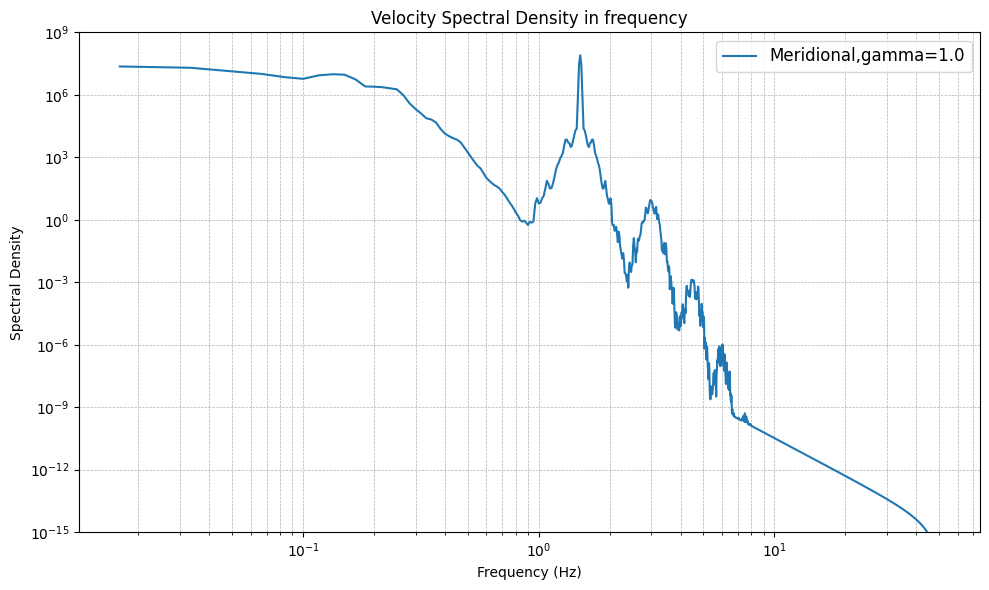

In [10]:
# Plot the velocity spectra 

#Gamma=np.array([0, 1e-3, 1e-2, 1e-1, 1, 5])
Gamma=np.array([1.0])
data = [None] * len(Gamma)  
u_spec = [None] * len(Gamma)     
v_spec = [None] * len(Gamma)     
vel_freq = [None] * len(Gamma)     
vel_spec = [None] * len(Gamma)  
for gamma in Gamma:
    index=np.where(Gamma==gamma)[0][0]
    data[index]= np.load(f"Data/Cellular_Flow/Spectra/wave0/velocity_spectrum,gamma_non_spatial={gamma},num_particles={num_particles},dt={dt},t_final={t_final}.npz")
for i in range(len(data)):
    u_spec[i] = data[i]["u_spec"]
    v_spec[i] = data[i]["v_spec"]
    vel_freq[i] = data[i]["vel_freq"]
    vel_spec[i] = data[i]["vel_spec"]

u_spec = np.array(u_spec, dtype=object)  
v_spec = np.array(v_spec, dtype=object)
vel_freq= np.array(vel_freq, dtype=object)  
vel_spec= np.array(vel_spec, dtype=object)  

plt.figure(figsize=(10, 6))

for idx, g in enumerate(Gamma):
    plt.loglog(vel_freq[idx],v_spec[idx],label=f"Meridional,gamma={g}")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Spectral Density')
    plt.title('Velocity Spectral Density in frequency')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)  
    plt.legend(fontsize=12)  
    plt.tight_layout()
    plt.ylim(1e-15,1e9)
    #plt.ylim(1e5,1e9)

filepath="Plots/Cellular_Flow/Spectrum/wave0/"
#plt.savefig(f"{filepath}Velocity_Spectra,f={1.5}gamma_spatial={Gamma}num_particles={num_particles},dt={dt},t_final={t_final}.png")

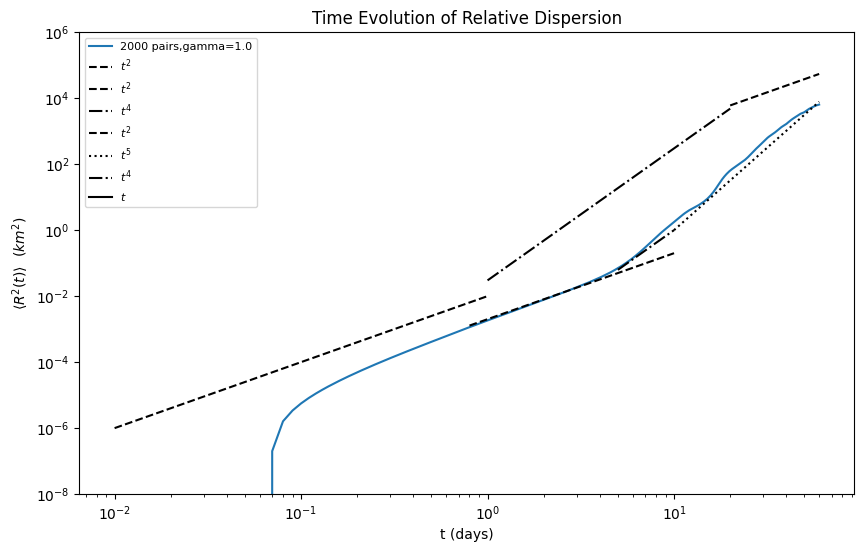

In [11]:
# Plot time evolution of relative dispersion

#Gamma=np.array([0, 1e-3, 1e-2, 1e-1, 1])
Gamma=np.array([1.0])
f=1.5
data = [None] * len(Gamma)  
dispersion = [None] * len(Gamma) 
kurtosis=[None] * len(Gamma) 
K_rel=[None] * len(Gamma) 
delta=[None] * len(Gamma)
fsle=[None] * len(Gamma) 
for idx, g in enumerate(Gamma):
    data[idx]= np.load(f"Data/Cellular_Flow/Stats/wave0/two_particles_stats,gamma_non_spatial={g},num_particles={num_particles},dt={dt},t_final={t_final}.npz")
    dispersion[idx] = data[idx]["relative_dispersion"]
    kurtosis[idx] = data[idx]["kurtosis"]
    K_rel[idx]= data[idx]["K_rel"]
    fsle[idx]=data[idx]["fsle"]
    delta[idx]=data[idx]["delta"]
    

dispersion = np.array(dispersion)  


plt.figure(figsize=(10, 6))
tt=dt*np.arange(1,int(t_final/dt)+1)

for idx, g in enumerate(Gamma):
    plt.loglog(tt[2:],dispersion[idx,idx,2:]-dispersion[idx,idx,0],label=f'{num_pairs} pairs,gamma={g}') # shape of dispersion is weird
    plt.ylim(1e-8,1e6)
    plt.title('Time Evolution of Relative Dispersion')
    plt.xlabel('t (days)')
    plt.ylabel(r'$\langle R^2(t) \rangle ~~ (km^{2})$')
    plt.legend()

mask1 = (0.8 <=tt) & (tt <=10) 
mask2 = (tt >= 10**1) & (tt <= 60)
mask3 = (5 <= tt) & (tt <= 10)
mask4 = tt >= 80
mask5 = tt <= 1
mask6 = (1 <= tt) & (tt <= 20)
mask7 = tt >=20
    
plt.loglog(tt[mask1], 0.2 * (tt[mask1] / 1e-1) ** 2 * 1e-4, 
           linestyle='dashed',color='k',label=r'$t^2$')

plt.loglog(tt[mask5], (tt[mask5] / 1e-1) ** 2 * 1e-4, 
           linestyle='dashed',color='k',label=r'$t^2$')

plt.loglog(tt[mask6], 300*(tt[mask6] / 1e1) ** 4, 
           linestyle='dashdot',color='k',label=r'$t^4$')

plt.loglog(tt[mask7],  0.15*(tt[mask7] / 1e-1)**2, 
           linestyle='dashed',color='k',label=r'$t^2$')

plt.loglog(tt[mask2], (tt[mask2] / 1e1) ** 5, 
           linestyle='dotted',color='k',label=r'$t^5$')

plt.loglog(tt[mask3], (tt[mask3] / 10) ** 4, 
           linestyle='dashdot',color='k',label=r'$t^4$')

plt.loglog(tt[mask4], 30 * (tt[mask4] / 1e-1), 
           linestyle='solid',color='k',label=r'$t$')

plt.legend(fontsize=8)  
#plt.xlim(2.5e-1,1)
#plt.ylim(1e-2,10)
filepath="Plots/Cellular_Flow/Stats/wave0/"
#plt.savefig(f"{filepath}Time_Evolution_Relative_Dispersion,f={f}gamma_non_spatial={Gamma}num_particles={num_particles},dt={dt},t_final={t_final}.png")

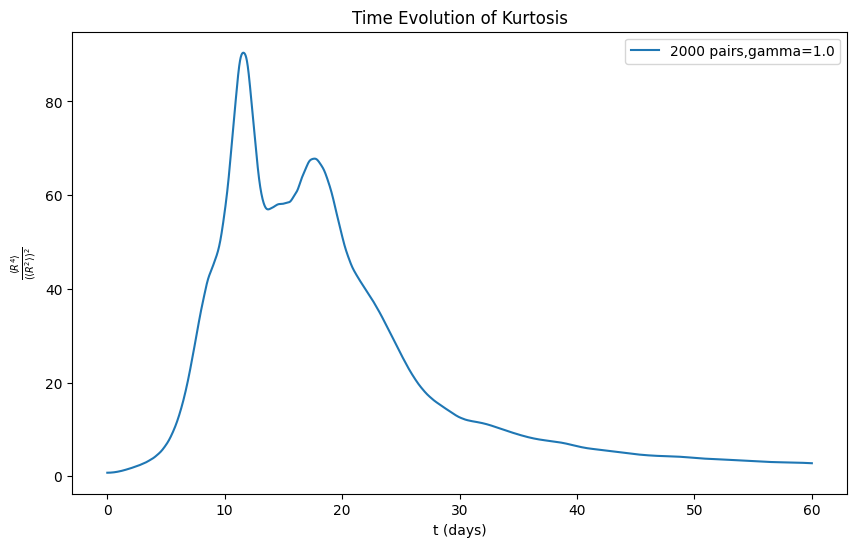

In [12]:
kurtosis = np.array(kurtosis)  

plt.figure(figsize=(10, 6))
tt=dt*np.arange(1,int(t_final/dt)+1)


for idx, g in enumerate(Gamma):
    plt.plot(tt[:],kurtosis[idx,idx,:],'-',label=f'{num_pairs} pairs,gamma={g}') # shape of dispersion is weird
    plt.title('Time Evolution of Kurtosis')
    plt.xlabel('t (days)')
    plt.ylabel(r'$\frac{\langle R^4 \rangle}{(\langle R^2 \rangle)^2}$')
    plt.legend()

filepath="Plots/Cellular_Flow/Stats/wave0/"
plt.savefig(f"{filepath}Time_Evolution_Kurtosis,f={f}gamma_non_spatial={Gamma}num_particles={num_particles},dt={dt},t_final={t_final}.png")

c:\Users\aymer\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aymer\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


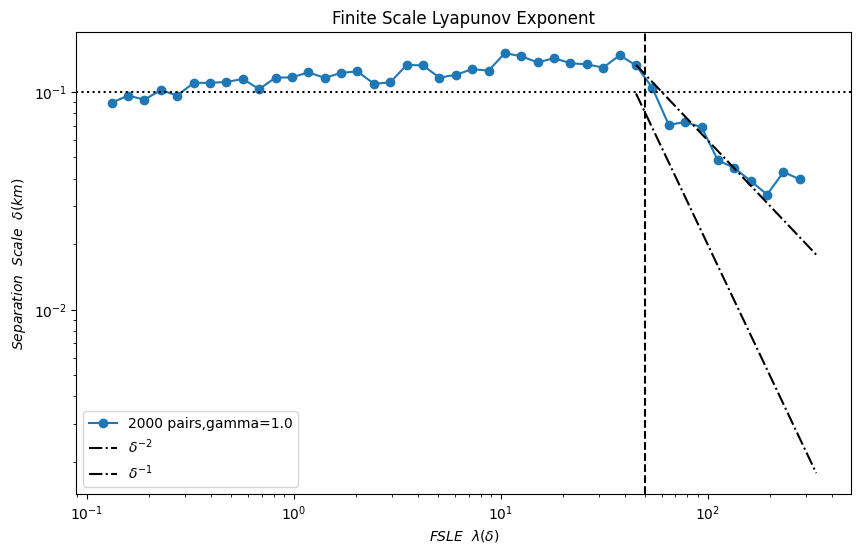

In [13]:
fsle=np.array(fsle, dtype=complex)
delta=np.array(delta, dtype=complex)

plt.figure(figsize=(10, 6))

for idx, g in enumerate(Gamma):
    plt.loglog(delta[idx,idx,1:-1],fsle[idx,0,1:-1],'-o',label=f'{num_pairs} pairs,gamma={g}') 
    plt.title('Finite Scale Lyapunov Exponent')
    plt.xlabel(r'$FSLE~~ \lambda(\delta)$')
    plt.ylabel(r'$Separation~~Scale~~ \delta (km)$')

plt.axhline(y=alpha_c[0]/L_c[0],color='black',linestyle='dotted')
plt.axvline(x=L_c[0]/2,color='black',linestyle='dashed')
mask = delta[idx, idx, 1:] > 45 
plt.loglog(delta[idx, idx, 1:][mask], 200 * delta[idx, idx, 1:][mask]**(-2), 
           color='black', linestyle='dashdot', label=r'$\delta^{-2}$')
plt.loglog(delta[idx, idx, 1:][mask], 6* delta[idx, idx, 1:][mask]**(-1), 
           color='black', linestyle='dashdot', label=r'$\delta^{-1}$')
plt.legend()
filepath="Plots/Cellular_Flow/Stats/wave0/"
plt.savefig(f"{filepath}FSLE,f={f}gamma_non_spatial={Gamma}num_particles={num_particles},dt={dt},t_final={t_final}.png")

In [ ]:
K_rel = np.array(K_rel, dtype=complex)  

plt.figure(figsize=(10, 6))
tt=dt*np.arange(1,int(t_final/dt)+1)
beta=8/5
Gamma=np.array([0, 1e-3, 1e-2, 1e-1, 1,5])
print(np.shape(K_rel))


for idx, g in enumerate(Gamma[:-2]):
    plt.loglog((dispersion[idx,idx,:])**(1/2),dispersion[idx,idx,:]/K_rel[idx,idx,:],'-',label=f'{num_pairs} pairs,gamma={g}') 

In [ ]:
tt=dt*np.arange(1,int(t_final/dt)+1)
dispersion=Relative_dispersion(particle_positions_cellular_x,particle_positions_cellular_y)
K_rel=Relative_diffusivity(particle_positions_cellular_x,particle_positions_cellular_y,tt)
print(dispersion[0]**(1/2))
plt.loglog(dispersion**(1/2),dispersion/K_rel,'-',label=f'{num_pairs} pairs,gamma={g}') 